   product_id          first_cgi_date
0  B00498DSVC 2015-01-28 05:31:52.000
1  B005SVI37S 2022-08-21 13:05:07.568
2  B009BA6EXW 2015-02-02 21:20:46.000
3  B009ECCZQC 2017-05-10 00:55:59.000
4  B00A8FA2JG 2020-09-02 12:02:01.036


/var/folders/vz/_y_gw0w915v4z_x6ps3fjwwm0000gn/T/ipykernel_74771/1009644502.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['first_cgi_date'].fillna(df['review_date'].min(), inplace=True)


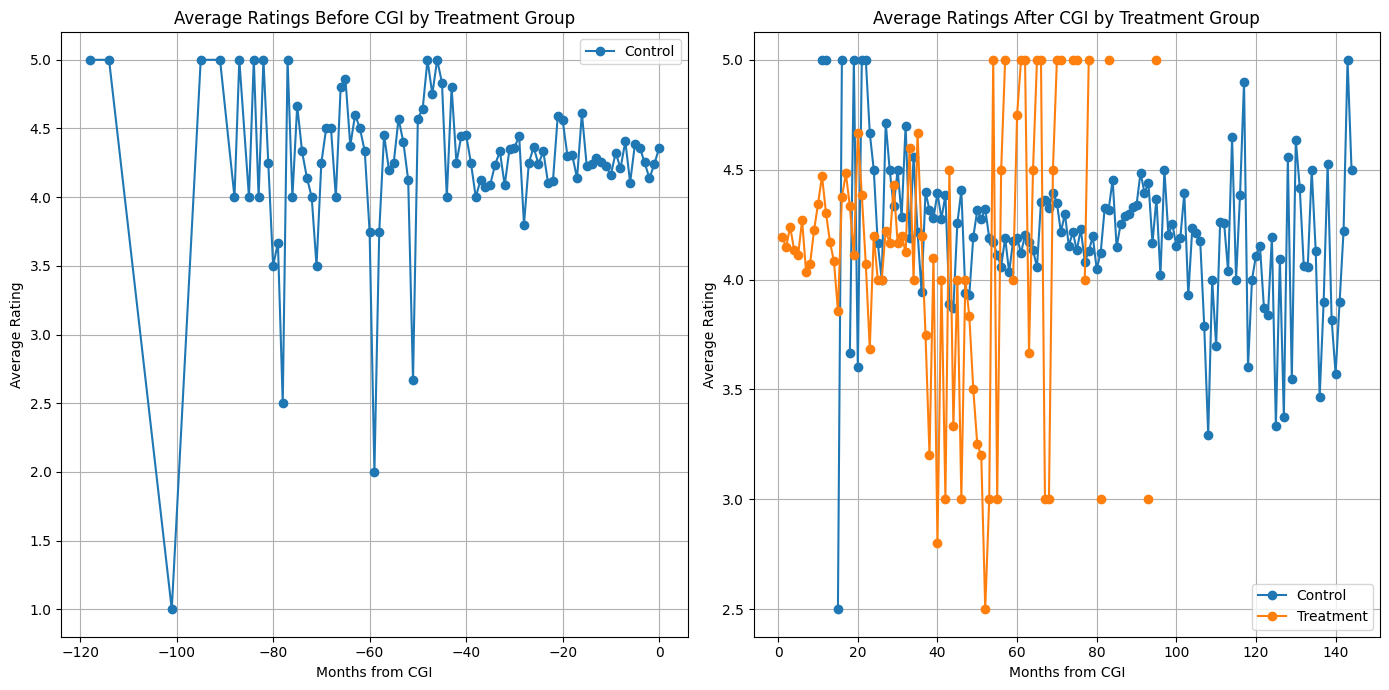

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('df_review_processed.csv')
df['review_date'] = pd.to_datetime(df['review_date'])

# Identify the first CGI date for each product
df_cgi = df[df['cgi_dummy'] == 1]
first_cgi_dates = df_cgi.groupby('product_id')['review_date'].min().reset_index()
first_cgi_dates.rename(columns={'review_date': 'first_cgi_date'}, inplace=True)

print(first_cgi_dates.head())

# Merge this back into the original DataFrame
df = df.merge(first_cgi_dates, on='product_id', how='left')

# For control group or missing CGI, fill 'first_cgi_date' with a placeholder date such as the minimum 'review_date'
df['first_cgi_date'].fillna(df['review_date'].min(), inplace=True)

# Calculate the time in months relative to the first CGI appearance
df['months_from_cgi'] = ((df['review_date'] - df['first_cgi_date']) / pd.Timedelta(days=30.44)).astype(int)

# Now you can filter and analyze trends
before_cgi = df[df['months_from_cgi'] <= 0]
after_cgi = df[df['months_from_cgi'] > 0]

# Example: Aggregate to see trends before and after CGI across treatment groups
trend_analysis_before = before_cgi.groupby(['treat_dummy', 'months_from_cgi'])['rating'].mean().unstack(0)
trend_analysis_after = after_cgi.groupby(['treat_dummy', 'months_from_cgi'])['rating'].mean().unstack(0)

# Plotting the results to visualize parallel trends
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(trend_analysis_before, marker='o')
plt.title('Average Ratings Before CGI by Treatment Group')
plt.xlabel('Months from CGI')
plt.ylabel('Average Rating')
plt.legend(['Control', 'Treatment'])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(trend_analysis_after, marker='o')
plt.title('Average Ratings After CGI by Treatment Group')
plt.xlabel('Months from CGI')
plt.ylabel('Average Rating')
plt.legend(['Control', 'Treatment'])
plt.grid(True)

plt.tight_layout()
plt.show()

df.to_csv('df_review_firstcgi.csv', index=False)

In [12]:
import pandas as pd

# Load your dataset
df = pd.read_csv('df_review_processed.csv')

# Ensure the 'review_date' column is in datetime format
df['review_date'] = pd.to_datetime(df['review_date'])

# Filter to get only the entries where a CGI image is present
cgi_present = df[df['cgi_dummy'] == 1]

# Get the first occurrence of CGI for each product
first_cgi_dates = cgi_present.groupby('product_id')['review_date'].min().reset_index()
first_cgi_dates.rename(columns={'review_date': 'first_cgi_date'}, inplace=True)

# Merge this back to the original DataFrame
df = df.merge(first_cgi_dates, on='product_id', how='left')

# Save the updated DataFrame with the 'first_cgi_date' column
df.to_csv('df_review_firstcgi.csv', index=False)

In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv('df_review_firstcgi.csv')

# Display the first few rows of the dataset and its structure (column names and types)
data.head(), data.dtypes

(   Unnamed: 0.1  Unnamed: 0  product_id  rating  text_len  title_len  month  \
 0             0           0  B01IIS2A3K     4.0        15          2     77   
 1             1           1  B01IIS2A3K     4.0        47         12     82   
 2             2           2  B01IIS2A3K     5.0        17          2     82   
 3             3           3  B01IIS2A3K     5.0        12          3     82   
 4             4           4  B01IIS2A3K     4.0        57          5     85   
 
    reviewer_expe  cgi_dummy  after_dummy  ...  TextLen TitleLen  \
 0              0          0            0  ...       15        2   
 1              0          0            0  ...       47       12   
 2              0          0            0  ...       17        2   
 3              0          0            0  ...       12        3   
 4              0          0            0  ...       57        5   
 
   CumulativeTextLen  CumulativeTitleLen  \
 0         45.928571            5.500000   
 1         15.000000

In [6]:
# Determine the treatment month based on the first occurrence of cgi_dummy == 1
treatment_month = data.loc[data['cgi_dummy'] == 1, 'month'].min()

print(treatment_month)

# Create Preit(j) and Postit(k) indicator variables for up to 5 months before and after treatment
for j in range(1, 7):  # Considering up to 6 months as per the paper's example
    data[f'Preit({j})'] = ((data['month'] == treatment_month - j) & (data['month'] >= treatment_month - 6)).astype(int)

for k in range(1, 7):  # Considering up to 6 months as per the paper's example
    data[f'Postit({k})'] = ((data['month'] == treatment_month + k) & (data['month'] <= treatment_month + 6)).astype(int)

# Also adding a cumulative dummy for months greater than or equal to 6 as described
data['Preit(6+)'] = (data['month'] < treatment_month - 5).astype(int)
data['Postit(6+)'] = (data['month'] > treatment_month + 5).astype(int)

# Normalize the coefficient of Preit(1) to zero (by not including it in the model)
# Now, we can display how these columns look to ensure they're correctly set up
data[['month', 'cgi_dummy'] + [f'Preit({j})' for j in range(1, 7)] + [f'Postit({k})' for k in range(1, 7)] + ['Preit(6+)', 'Postit(6+)']].head(20)


55


,month,cgi_dummy,Preit(1),Preit(2),Preit(3),Preit(4),Preit(5),Preit(6),Postit(1),Postit(2),Postit(3),Postit(4),Postit(5),Postit(6),Preit(6+),Postit(6+)
0,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
import statsmodels.api as sm

# Selecting relevant predictors, excluding Preit(1) as its coefficient should be normalized to zero
predictors = [col for col in data.columns if 'Preit' in col or 'Postit' in col] + ['Volume', 'Valence', 'Variance' ,'text_len', 'title_len', 'reviewer_expe']
predictors.remove('Preit(1)')  # Normalizing Preit(1) coefficient to zero by excluding it

# Adding constant for intercept
X = sm.add_constant(data[predictors])
y = data['rating']

# Build and fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Display the results summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     43.52
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          5.45e-156
Time:                        20:00:53   Log-Likelihood:                -14678.
No. Observations:                9484   AIC:                         2.940e+04
Df Residuals:                    9464   BIC:                         2.954e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.3070      0.180     12.795      0.000       1.954       2.660
Preit(2)         -0.0493      0.272     -0.181      0.856      -0.583       0.484
Preit(3)          0.0816      0.281      0.290      0.772      -0.469       0.632
Preit(4)         -0.6344      0.346     -1.833      0.067      -1.313       0.044
Preit(5)          0.2050      0.336      0.611      0.541      -0.453       0.863
Preit(6)         -0.2557      0.297     -0.861      0.389      -0.838       0.326
Postit(1)        -0.3055      0.254     -1.201      0.230      -0.804       0.193
Postit(2)        -0.0528      0.249     -0.212      0.832      -0.540       0.435
Postit(3)        -0.0560      0.233     -0.241      0.810      -0.512       0.400
Postit(4)         0.0312      0.212      0.147      0.883      -0.384       0.447
Postit(5)         0.0048      0.204      0.024      0.981      -0.396       0.405
Postit(6)         0.0605      0.145      0.416      0.677      -0.224       0.345
Preit(6+)         0.1607      0.179      0.899      0.369      -0.190       0.511
Postit(6+)       -0.0049      0.142     -0.034      0.973      -0.284       0.274
Volume           -0.0012      0.000     -3.203      0.001      -0.002      -0.000
Valence           0.4867      0.023     21.375      0.000       0.442       0.531
Variance          0.0223      0.019      1.172      0.241      -0.015       0.060
text_len         -0.0007      0.000     -2.096      0.036      -0.001   -4.44e-05
title_len        -0.0305      0.003     -8.963      0.000      -0.037      -0.024
reviewer_expe    -0.0398      0.183     -0.218      0.828      -0.398       0.319
==============================================================================
Omnibus:                     1978.418   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3501.584
Skew:                          -1.360   Prob(JB):                         0.00
Kurtosis:                       4.211   Cond. No.                     2.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Code to read csv file and make treatment month

In [15]:
import pandas as pd

# Load the dataset
df = pd.read_csv('df_review_processed.csv')

# Determine the treatment month for each product
treatment_months = df[df['cgi_dummy'] == 1].groupby('product_id')['month'].min().reset_index()

# Rename the columns for clarity
treatment_months.rename(columns={'month': 'treatment_month'}, inplace=True)

# Save to CSV
treatment_months.to_csv('treatment_months.csv', index=False)

print("Treatment months saved to 'treatment_months.csv'.")

Treatment months saved to 'treatment_months.csv'.
